In [50]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Проект e-learning: вариант 2  
Продакт-менеджер Василий попросил вас проанализировать завершенные уроки и ответить на следующие вопросы:

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) (7 баллов).

2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (5 баллов)

3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). (5 баллов) 

4. Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3). (8 баллов)

5. Напиши функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. (10 баллов) 

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 0.1 до 0.5, monetary от 55 до 72 баллов. Описание подхода можно найти тут. (35 баллов)

*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен  
[обсуждение промежуточного проекта с рецензентом](intermed_proj_review.md)

#### Загрузка рабочих файлов
[описание файлов](intermed_proj_files.md)  
df_ass - информация об оценках в тесте  
df_cou - предметы по семестрам  
df_stass - результаты тестов студентов  
df_streg - информация о регистрации студента

In [2]:
df_ass = pd.read_csv('assessments.csv')
df_cou = pd.read_csv('courses.csv')
df_stass = pd.read_csv('studentAssessment.csv')
df_streg = pd.read_csv('studentRegistration.csv')

#### Задание 1
Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

In [3]:
#выявляем те тесты которые являются экзаменами
df_ass_exam = df_ass.query('assessment_type == "Exam"')
df_stass_exam = df_ass_exam.merge(df_stass, on = 'id_assessment')

#оставляем только успешно сданные экзамены
#группируем по студентам, считаем количество экзаменов
#оставляем только тех у кого один успешно сданный экзамен
quant_course = df_stass_exam \
    .query('score >= 40') \
    .groupby('id_student', as_index = False) \
    .agg({'date_submitted': 'count'}) \
    .rename(columns = {'date_submitted': 'quantity'}) \
    .query('quantity == 1')

In [4]:
quant_course.shape

(3802, 2)

In [5]:
#ответ - успещно сдали только один курс 3802 студента

#### Задание 2
Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью   
*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [6]:
#определяем сколько видов экзаменов сдавали студенты
df_stass_exam.code_module.nunique()

2

In [7]:
#определяем общее количество сдач по каждому экзамену
tests = df_stass_exam \
    .groupby('id_assessment', as_index = False) \
    .agg({'date_submitted': 'count'}) \
    .rename(columns = {'date_submitted': 'quantity'})

#определяем количество успешных сдач по каждому экзамену
tests_good = df_stass_exam \
    .query('score >= 40') \
    .groupby('id_assessment', as_index = False) \
    .agg({'date_submitted': 'count'}) \
    .rename(columns = {'date_submitted': 'quant_good'})

#объединяем датафреймы с общим количеством сдач и с количеством успешных сдач
#связываем эти данные с курсами
tests_m = pd.merge(pd.merge(tests, tests_good, on='id_assessment'),df_ass,on='id_assessment')

#вычисляем завершаемость и добавляем соответствующий столбец
tests_m['estimate'] = tests_m['quant_good']/tests_m['quantity']

In [8]:
#определяем экзамен и курс с самой высокой завершаемостью
tests_m.sort_values(by='estimate', ascending=False).head(1)

,id_assessment,quantity,quant_good,code_module,code_presentation,assessment_type,date,weight,estimate
4,25361,524,485,DDD,2014B,Exam,241.0,100.0,0.925573


In [9]:
#определяем экзамен и курс с самой низкой завершаемостью
tests_m.sort_values(by='estimate', ascending=True).head(1)

,id_assessment,quantity,quant_good,code_module,code_presentation,assessment_type,date,weight,estimate
2,25340,602,504,DDD,2013B,Exam,240.0,100.0,0.837209


In [10]:
#таким образом выявлено:
#экзамен с самой высокой здаваемостью (0.925573): 25361, предмет: DDD 
#экзамен с самой низкой здаваемостью (0.837209): 25340,  предмет: DDD

#### Задание 3
По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

In [11]:
#исследуем данные по экзаменам, в частности смотрим -  какие бывают даты сдачи (дедлайны) от начала семестра
#видим что есть конкретные дедлайны по сдаче, а есть графы c Nan, т.е. срок сдачи не определен
df_ass_exam = df_ass.query('assessment_type == "Exam"')
df_ass_exam.date.unique()

array([ nan, 240., 261., 241., 235., 228., 222., 236., 227., 229.])

In [12]:
#смотрим на даты о сдаче экзаменов студентами
#никаких аномальных значений (nan или отрицательные) нет
df_stass_exam.date_submitted.unique()

array([230, 234, 236, 243, 237, 238, 242, 266, 244, 245, 248, 256, 251,
       250, 259, 249, 252, 285, 231, 229, 233, 241, 235, 255, 279],
      dtype=int64)

In [13]:
#для начала определяем случаются ли повторные сдачи у студентов одного и того же предмета,
# т.к.в условии указано что сдачей считается последнее успешное прохождение экзамена
# для этого, для начала смотрим сколько всего видов уникальных экзаменов сдавали студенты
df_stass_exam.code_module.unique()

array(['CCC', 'DDD'], dtype=object)

In [14]:
#теперь смотрим сколько всего экзаменов сдавали ученики, т.е. если были значения больше двух, то пересдачи были
#для этого группируем по id студента и находим количество сдач для каждого студента
df_stass_exam_uniq = df_stass_exam \
    .groupby('id_student', as_index = False) \
    .agg({'score': 'count'}) \
    .rename(columns = {'score': 'quant_exams'})

In [15]:
#видим что максимальное количество сдаваемых экзаменов 2, т.е. пересдач не было
df_stass_exam_uniq.quant_exams.max()

2

In [16]:
#к решению можно подходить двумя путями - с учетом дедлайна по экзамену и без учета дедлайна
#смотрим были ли сдачи экзамена после дедлайна
df_stass_exam2 = df_stass_exam.query('date_submitted > date')

#видим, что есть 7 таких случаев
df_stass_exam2.shape

(7, 10)

In [17]:
#выявляем только те экзамены, которые сданы в срок и для которых дедлайн не обозначен
df_stass_exam3 = df_stass_exam.query(
    'date_submitted <= date | date != date')

In [18]:
df_stass_exam3.shape

(4952, 10)

In [19]:
#таким образом имеем два массива:
#df_stass_exam - все экзамены
#df_stass_exam3 - экзамены сданные в срок

In [20]:
#определяем средний срок сдачи экзаменов для обоих случаев
exams_mean1 = df_stass_exam.groupby('code_module', as_index = False) \
    .agg({'date_submitted':'mean'})
exams_mean2 = df_stass_exam3.groupby('code_module', as_index = False) \
    .agg({'date_submitted':'mean'})

In [21]:
exams_mean1

,code_module,date_submitted
0,CCC,239.408877
1,DDD,237.901445


In [22]:
exams_mean2

,code_module,date_submitted
0,CCC,239.408877
1,DDD,237.888047


In [23]:
#видим, что результаты почти одинковые. Небольшие отличия есть только для экзамена по предмету DDD,
#т.е. DDD иногда сдают не в срок

#### Задание 4
Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3)

In [24]:
#исследуем файл данных с информацией о регистрации студента
#смотрим, есть ли значения NaN в колонке date_registration
df_streg.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [25]:
#выделяем записи с NaN в колонке date_registration в отдельный массив
#смотрим в этом массиве -  какие встречаются даты отмены регистрации (date_unregistration) 
#выявляем, что в большинстве своем отмена регистрации происходит до начала семестра
#в то же время встречаются значения Nan и положительные значения
date_reg_nan = df_streg[df_streg['date_registration'].isna()]
date_reg_nan.date_unregistration.unique()

array([  nan,   -1.,  -33., -126.,  -38., -142., -109., -149.,  -36.,
        -61.,  -24., -168., -156., -152.,  -29.,  -65., -116.,  -40.,
        -75., -196.,  -81., -213.,   12., -163.,    5.,  146., -166.,
         -2.,  -46., -107., -365., -119.,  -88.,  -82.,  -53.,    9.])

In [26]:
#объединяем данный массив с данными о сданных тестах и видим, 
#что несмотря на то что студенты не являются зарегистрированными на курсе
#они сдают тесты и экзамены после начала семестра
date_reg_nan_merge = date_reg_nan.merge(df_stass, on='id_student')
date_reg_nan_merge.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,id_assessment,date_submitted,is_banked,score
0,CCC,2014B,394791,NaN,-61.0,24291,20,0,72.0
1,CCC,2014B,394791,NaN,-61.0,24292,116,0,72.0
2,CCC,2014B,394791,NaN,-61.0,24293,158,0,65.0
3,CCC,2014B,394791,NaN,-61.0,24294,204,0,69.0
4,CCC,2014B,394791,NaN,-61.0,24295,21,0,44.0


In [27]:
#таким образом предлагается использовать эти данные для анализа оттока студентов с курса 

In [28]:
#определяем курс с самым высоким количеством регистраций
df_streg.groupby('code_module', as_index = False) \
    .agg({'date_registration': 'count'}) \
    .rename(columns={"date_registration": "number_of_reg"}) \
    .sort_values(by=['number_of_reg'], ascending = False).head(3)

,code_module,number_of_reg
1,BBB,7900
5,FFF,7751
3,DDD,6257


In [29]:
#определяем курс с самым высоким оттоком
df_streg.groupby('code_module', as_index = False) \
    .agg({'date_unregistration': 'count'}) \
    .rename(columns={"date_unregistration": "number_of_unreg"}) \
    .sort_values(by=['number_of_unreg'], ascending = False).head(3)

,code_module,number_of_unreg
5,FFF,2380
1,BBB,2377
3,DDD,2235


#### Задание 5
Напиши функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

In [30]:
#когорта, это группа сформированная по временному признаку
#в нашем случае, отрезком времени является семестр
#проверяем какие семестры присутствуют в данных
df_ass['code_presentation'].unique()

array(['2013J', '2014J', '2013B', '2014B'], dtype=object)

In [31]:
#определяем функцию get_semester_cogort для выполнения когортного (семестрового) анализа
#исходными данными для функции являются датафреймы, содержащие 
#информацию о тестах (ass) и информацию о сдаче тестов студентами (stass)

def get_semester_cogort(ass, stass):
    
    #завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен
    
    #выявляем те тесты которые являются экзаменами, объединем с результатами их сдачи студентами
    df_ass_exam = ass.query('assessment_type == "Exam"')
    df_stass_exam = df_ass_exam.merge(stass, on = 'id_assessment')
    
    #делаем группировку по семестрам и определяем общее количество попыток сдать экзамен
    tests = df_stass_exam.groupby('code_presentation', as_index = False) \
        .agg({'score': 'count'}) \
        .rename(columns = {'score': 'all_tests'})
    
    #оставляем только успешные сдачи экзамена
    #делаем группировку по семестрам и определяем общее количество попыток сдать экзамен
    #и среднюю дату успешной сдачи экзамена
    tests_good = df_stass_exam.query('score >= 40') \
    .groupby('code_presentation', as_index = False) \
    .agg({'score': 'count', 'date_submitted': 'mean'}) \
    .rename(columns = {'score': 'good_tests', 'date_submitted' : 'post_date'})
    
    #объединяем два датафрейма
    #вычисляем завершаемость
    tests_analit =  tests.merge(tests_good, on='code_presentation')
    tests_analit['completeness'] = tests_analit['good_tests']/tests_analit['all_tests']
    
    return tests_analit

In [32]:
#запускаем функцию
get_semester_cogort(df_ass, df_stass)

,code_presentation,all_tests,good_tests,post_date,completeness
0,2013B,602,504,230.164683,0.837209
1,2013J,968,878,239.509112,0.907025
2,2014B,1271,1149,232.997389,0.904013
3,2014J,2118,1861,243.680279,0.878659


In [33]:
#таким образом выявлено:  
#самая высока завершаемость наблюдалась в семестре 2013J (0.91)  
#самый долгий средний срок сдачи курсов наблюдался в семестре 2014J (243.7 дня)

#### Задание 6
Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики:  
R - среднее время сдачи одного экзамена (recency),  
F - завершаемость курсов (frequency),  
M - среднее количество баллов, получаемое за экзамен (monetary).  
Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 0.1 до 0.5, monetary от 55 до 72 баллов. 

#### Задание 6 - Первый этап
Вычисляем для каждого студента метрики:  
R - среднее время сдачи одного экзамена (recency),  
F - завершаемость курсов (frequency),  
M - среднее количество баллов, получаемое за экзамен (monetary).

In [34]:
#группируем по каждому студенту и определяем среднее время сдачи одного экзамена (R - recency)
df_1 = df_stass_exam.groupby('id_student', as_index = False) \
    .agg({'date_submitted': 'mean'}) \
    .rename(columns = {'date_submitted': 'mean_date_R'})

In [35]:
#группируем по каждому студенту и определяем общее количество попыток сдать экзамен
df_all_exams = df_stass_exam.groupby('id_student', as_index = False) \
    .agg({'date_submitted': 'count'}) \
    .rename(columns = {'date_submitted': 'all_tests'})
#оставляем только успешные сдачи экзамена
#группируем по каждому студенту и определяем общее количество успешных экзаменов
df_good_exams = df_stass_exam.query('score >= 40') \
    .groupby('id_student', as_index = False) \
    .agg({'date_submitted': 'count'}) \
    .rename(columns = {'date_submitted': 'good_tests'})
#объединям два датафрейма
df_2 = df_all_exams.merge(df_good_exams, on = 'id_student', how = 'left')
#определяем завершаемость курсов (успешные сдачи экзамена/общее количество попыток сдать экзамен; F - frequency)
df_2['completeness_F'] = df_2.good_tests/df_2.all_tests

In [36]:
#определяем среднее количество баллов, получаемое за экзамен (M -monetary)
df_3 = df_stass_exam.groupby('id_student', as_index = False) \
    .agg({'score': 'mean'}) \
    .rename(columns = {'score': 'mean_score_M'})

In [37]:
#объединяем все три датафрейма и оставляем только нужные стрлбцы
df = pd.merge(pd.merge(df_1, df_2, on='id_student'),df_3,on='id_student')
df = df.drop(['all_tests','good_tests'], 1)

In [38]:
#проверяем полученный датафрейм на значения Nan
df.isna().sum()

id_student          0
mean_date_R         0
completeness_F    536
mean_score_M        0
dtype: int64

In [39]:
#заменяем значения Nan на 0 в столбце завершаемости курсов
df['completeness_F'] = df['completeness_F'].replace(np.nan, 0)

In [40]:
#проверяем в каком количестве встречается каждое из значений в столбце завершаемости курсов
df['completeness_F'].value_counts()

1.0    4069
0.0     536
0.5      28
Name: completeness_F, dtype: int64

In [41]:
#итоговый датафрейм
df.head()

,id_student,mean_date_R,completeness_F,mean_score_M
0,23698,243.0,1.0,80.0
1,24213,236.0,1.0,58.0
2,27116,243.0,1.0,96.0
3,28046,237.0,1.0,40.0
4,28787,243.0,1.0,44.0


#### Задание 6 - Второй этап
Смотрим распределение полученных значений

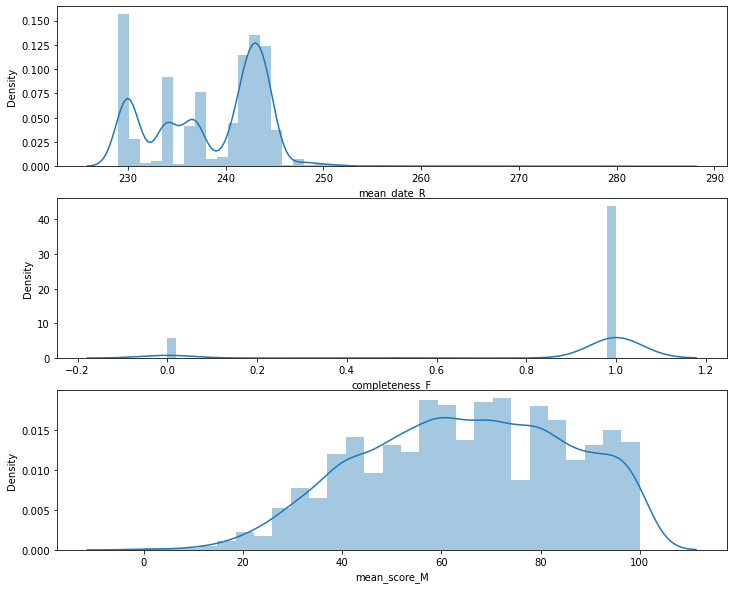

In [51]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1); sns.distplot(df['mean_date_R'])
plt.subplot(3, 1, 2); sns.distplot(df['completeness_F'])
plt.subplot(3, 1, 3); sns.distplot(df['mean_score_M'])
plt.show()

#### Задание 6 - Третий этап
Делаем сегментацию и определяем значения R, F и M

In [44]:
#значения R и M у нас непрерывные
#таким образом сегменты для них будут определяться разделением всего массива на три равные части
quantiles = df.quantile(q=[0.30, 0.60])
quantiles = quantiles.to_dict()
def RFM_rm(x,p,d):
    if x <= d[p][0.30]:
        return 1
    elif x <= d[p][0.60]:
        return 2
    else:
        return 3

In [45]:
#определяем значение R
df['R'] = df['mean_date_R'].apply(RFM_rm, args=('mean_date_R',quantiles))

In [46]:
#значения F у нас дискретны - 0, 0.5 и 1 
#таким образом сегментация будет осуществляться строго по этим значениям
f_values=[]
for i in df['completeness_F']:
    if i == 0:
        a = 1
    elif i == 0.5:
        a = 2
    else:
        a = 3
    f_values.append(a)
#определяем значение F
df['F'] = f_values

In [47]:
#определяем значение M
df['M'] = df['mean_score_M'].apply(RFM_rm, args=('mean_score_M',quantiles))

In [48]:
df['RFMScore'] = df.R.map(str) + df.F.map(str) + df.M.map(str)
df.head()

,id_student,mean_date_R,completeness_F,mean_score_M,R,F,M,RFMScore
0,23698,243.0,1.0,80.0,3,3,3,333
1,24213,236.0,1.0,58.0,2,3,2,232
2,27116,243.0,1.0,96.0,3,3,3,333
3,28046,237.0,1.0,40.0,2,3,1,231
4,28787,243.0,1.0,44.0,3,3,1,331


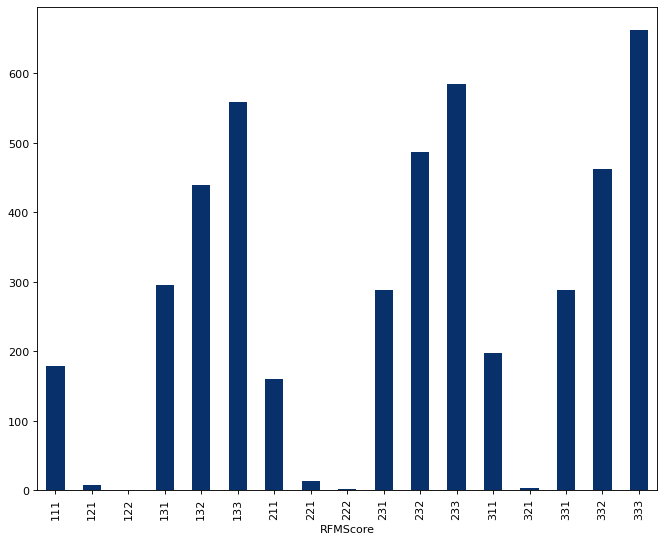

In [49]:
#смотрим какие группы преобладают
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
df.groupby('RFMScore').agg('mean_date_R').count().plot(kind='bar', colormap='Blues_r')
plt.show()

R - среднее время сдачи одного экзамена (recency),  
F - завершаемость курсов (frequency),  
M - среднее количество баллов, получаемое за экзамен (monetary).  

Выявлено, что преобладает студенты с завершаемостью курсов = 1 (F = 3)   
Из них преобладают студенты с наиболее высокой средней оценкой за экзамен (M = 3)  
Среднее время сдачи не связано со средним количеством баллов получаемых за экзамен

[обсуждение промежуточного проекта с рецензентом](intermed_proj_review.md)